# VOYAGER LISM EDA

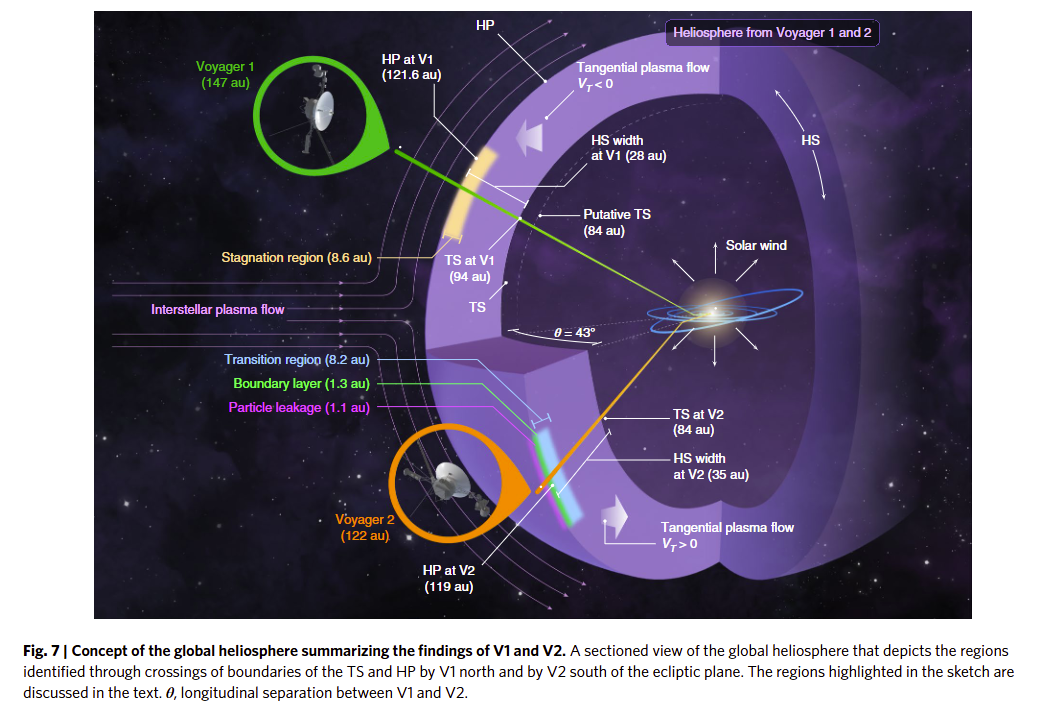

*From [Krimigis et al. (2019)](https://www.nature.com/articles/s41550-019-0927-4.pdf)*


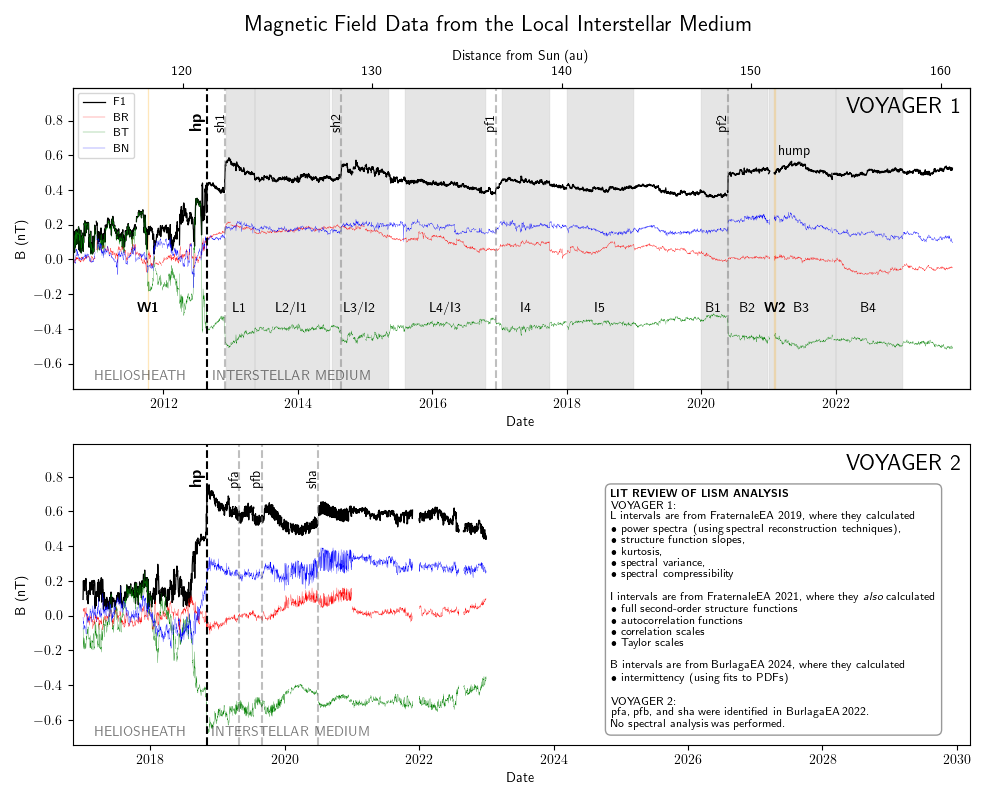

Daily averages


### LISM data summary
[Voyager metadata](https://spdf.gsfc.nasa.gov/pub/data/voyager/documents/vgrmag_website/data.html)

- We have 14 years of data from the LISM across two spacecraft
- Pre-2019, a few large (~1 year) V1 intervals have been studied in depth with regards to their turbulent properties
- Post-2019, V1 has only been studied in terms of intermittency via PDF fits
- No V2 data has been studied with regards to turbulence properties
- No density data for V1 is directly available due to broken plasma instrument (PLS), but has been derived from electron plasma oscillations (PWS) given a known relationship with frequency:

### What has been discovered?

Best summary: *[Fraternale, Federico, et al. "Exploring turbulence from the Sun to the local interstellar medium." White paper, Heliophysics (2024).](https://assets.pubpub.org/gii0hyrt/Exploring%20Turbulence%20from%20the%20Sun%20to%20the%20Local%20Interstellar%20Medium-51694023959026.pdf)*

Less recent but with nice description of shocks etc.: *[Mostafavi, P., et al. "Shocks in the very local interstellar medium." Space science reviews 218.4 (2022): 27.](https://link.springer.com/content/pdf/10.1007/s11214-022-00893-4.pdf)*

- The LISM is **compressible**: featuring shocks and pressure fronts.
- Magnetic field spectra show some -2 power-laws, indicative of *Burgers-like* turbulence. This is turbulence where energy cascades through **shock structures** rather than vortex stretching.
- Low speed means it does not meet Taylor's assumption
- The portion of the LISM affected by the presence of the heliosphere is called the very local interstellar medium (VLISM). 
- A heliospheric boundary layer (HBL) with decreased plasma density and draped magnetic field is adjacent to the HP on the VLISM side
- In the outer heliosphere, pick-up ions are a source of energy
- As well as Voyager, ISM turbulence has been investigated by
    - IBEX observations of ENAs
    - Radio observations of atomic hydrogen
    - Scintillation of light from stars
    - Density fluctuations of interstellar dust and gas

#### Heliopause crossings
- [The derived electron density is largely what was used to infer that the spacecraft had crossed the heliopause](https://www.nasa.gov/science-research/heliophysics/as-nasas-voyager-1-surveys-interstellar-space-its-density-measurements-are-making-waves/), which increased from 0.002/cm $^3$ to 0.1/cm $^3$
- Note however that for V1, the magnetic field direction did not change significantly, especially visible in the radial and normal components. This was later explained by draping of the interstellar magnetic field across the helioapuse, forming a tangential discontinuity.
- V2 crossing was less ambiguous

### What are the issues with the data?

#### Uncertainties
See Figs 1 and 2 of [RankinEA (2023)](https://iopscience.iop.org/article/10.3847/2041-8213/acbd4e/pdf). **Add as transparent bands to the time series**.

#### Bad data
- Magrolls
    - Occur during a ≈5.5-hr interval every two or three months.
    - Stopped for a bit due to power concerns. E.g., no magrolls from about 2015.2 to beginning of 2017 for V2. 
    - **Generally removed from calibrated data**.
- Magcals (for $B_R$) 
    - occur ever ≈29 days. These are attempts to calibrate $B_R$ with resepect to the average expected value for the Parker spiral, **an approach which breaks down outside the heliosphere**. Therefore, "...we conclude that **the $B_R$ component derived from V1 and V2 measurements is questionable and in its present form should not be included in analyses of the large-scale LISMF** ([RankinEA (2023)](https://iopscience.iop.org/article/10.3847/2041-8213/acbd4e/pdf)).
- Individual outliers points
    - FratEA2019 cleaned outliers with a 48 rolling variance threshold. Data were rotated to mean field coordinates (B parallel and 2 B perp)

#### Data gaps

- Typically the spacecraft are only tracked 8-12hr/day, **leading to typical missing fractions of ...%**. Removal of bad data above leads to further gaps. 
- Power spectra:
    - **FraternaleEA** (both papers, I and L intervals) handled these with a combination of spectral reconstruction methods
- Structure functions:
    - **FraternaleEA2019 (L ints)** handled gaps by implementing a statistical thresholding based on relative sample size when computing slopes. *I have reproduced this procedure below*.
    - **FraternaleEA2021 (I ints)** performed a convergence study based on statistical theory of de Wit in order to validate the reliability of their SFs up to the fourth order (the order needed to compute kurtosis). They also computed their SFs using 6-point averaged time series (i.e. down-sampled from 48s to 288s/data point). This reduced the intensity of small-scale fluctuations by a factor of ~1.5. They performed this same averaging prior to computing ACFs.

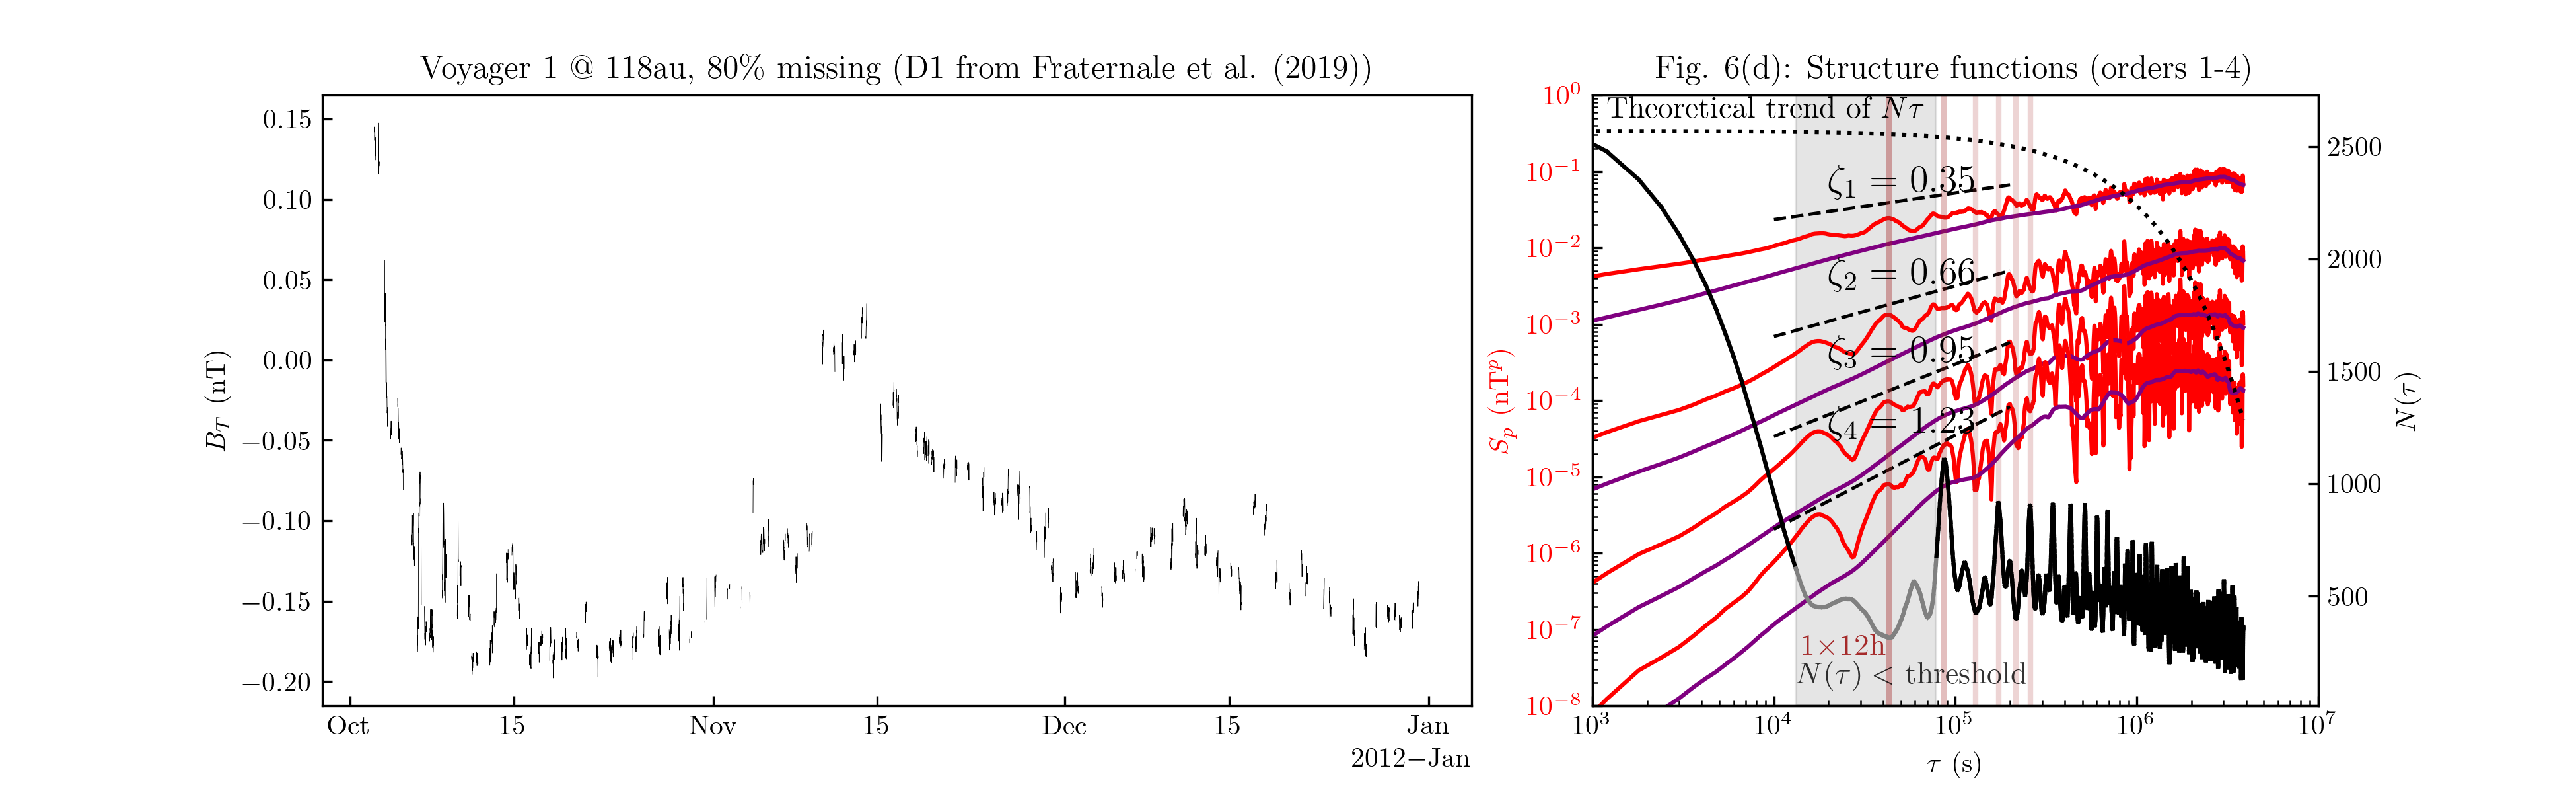

# Outlier searching

Example of calibration roll in V1 from January 2013 (code above)

![alt text](0c2401b0-230c-45b6-a089-ee007d0ec04a.png)

In [1]:
import numpy as np
import pandas as pd
import math as m
import pickle
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sunpy.timeseries import TimeSeries
from matplotlib.dates import DateFormatter

import sys
import os
import glob

sys.path.append(os.path.abspath(".."))
# So that I can read in the src files while working here in the notebooks/ folder
# NB: does not affect working directory, so still need ../data e.g. for reading data

import src.utils as utils
import src.params as params
import src.sf_funcs as sf

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

### Define funcs

In [2]:
# Function to identify separate groups of adjacent outliers
def identify_outlier_groups(outliers_series, max_gap="1h"):
    """
    Identify groups of adjacent outliers with gaps no larger than max_gap.
    Returns a list of DataFrames, each containing a group of outliers.
    """
    if outliers_series.empty:
        return []

    # Convert to DataFrame for easier manipulation
    outliers_df = outliers_series.reset_index()
    outliers_df.columns = ["timestamp", "value"]

    # Sort by timestamp
    outliers_df = outliers_df.sort_values("timestamp")

    # Initialize groups
    groups = []
    current_group = [outliers_df.iloc[0]]

    # Group adjacent outliers
    for i in range(1, len(outliers_df)):
        current_time = outliers_df.iloc[i]["timestamp"]
        previous_time = current_group[-1]["timestamp"]

        # Check if the gap between current and previous point is small enough
        if current_time - previous_time <= pd.Timedelta(max_gap):
            # Add to current group
            current_group.append(outliers_df.iloc[i])
        else:
            # Start a new group
            groups.append(pd.DataFrame(current_group))
            current_group = [outliers_df.iloc[i]]

    # Add the last group
    if current_group:
        groups.append(pd.DataFrame(current_group))

    return groups

In [3]:
threshold = 17
window_size = 3000


# Function to detect outliers using Hampel filter
def detect_outliers(
    series, window_size=window_size, threshold=threshold, min_mad=0.002
):
    # Compute the rolling median
    rolling_median = series.rolling(window=window_size, min_periods=1).median()

    # Use this pattern when possible:
    rolling_abs_dev = np.abs(series - rolling_median)
    rolling_mad = rolling_abs_dev.rolling(window=window_size, min_periods=1).median()

    # Apply minimum MAD threshold
    rolling_mad = np.maximum(rolling_mad, min_mad)

    rolling_kurt = series.rolling(window=100, min_periods=1).kurt()

    # Calculate deviation scores
    deviation_scores = np.fabs(series - rolling_median) / rolling_mad

    # Identify outliers
    outliers = series[deviation_scores > threshold]

    # Compute the rolling fraction of missing data over a window of one week
    rolling_missing = series.isna().rolling(window="24h", min_periods=1).mean()

    return outliers, rolling_median, rolling_mad, rolling_kurt, rolling_missing

## Run analysis

Takes ~20s to load 1 Voyager file (1 year)

In [49]:
year = 2016
cadence = "48s"

spacecraft = "voyager1"

data = TimeSeries(
    f"../data/raw/voyager/{spacecraft}_{cadence}_mag-vim_{year}0101_v01.cdf",
    concatenate=True,
)

df_raw = data.to_dataframe()[str(year):]
df_raw = df_raw.loc[:, params.mag_vars_dict["voyager"]]

In [50]:
df = df_raw.resample(cadence).mean()
del data, df_raw
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657001 entries, 2016-01-01 00:00:00 to 2016-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   F1      156678 non-null  float32
 1   BR      156678 non-null  float32
 2   BT      156678 non-null  float32
 3   BN      156678 non-null  float32
dtypes: float32(4)
memory usage: 15.0 MB
None


In [51]:
df.isna().sum() / len(df)

F1    0.761525
BR    0.761525
BT    0.761525
BN    0.761525
dtype: float64

In [52]:
# Example of calibration roll
#plt.plot(df["2013-01-01 22:00":"2013-01-02 02:00"])
# plt.xticks(rotation=45)
# plt.legend()

## Hampel filter

In [53]:
# Detect outliers for each compoment, then combine

outliers = {}
rolling_median = {}
rolling_mad = {}
rolling_kurt = {}
rolling_missing = {}

components = df.columns
for component in components:
    outliers[component], rolling_median[component], rolling_mad[component], rolling_kurt[component], rolling_missing[component] = detect_outliers(df[component])

# Combine the timestamps for all outliers
all_outlier_times = pd.concat(outliers.values()).sort_index().index

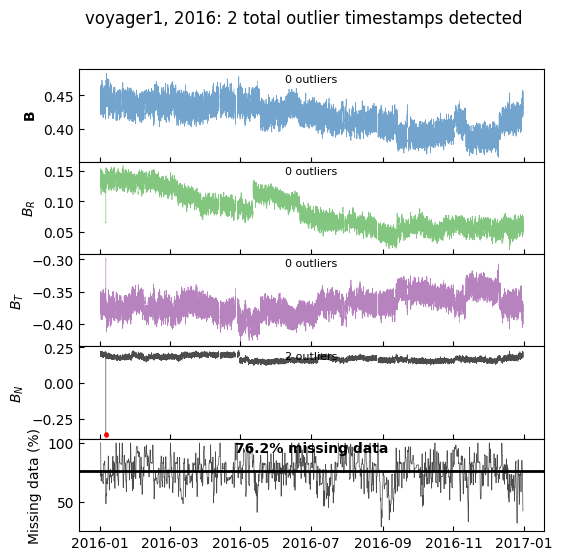

In [54]:
fig, ax = plt.subplots(len(components)+1, 1, figsize=(6, 6), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove white space between subplots

labels = {"BN": "$B_N$", "BR": "$B_R$", "BT": "$B_T$", "F1": "$\\mathbf{B}$"}

colors = ["#377eb8", "#4daf4a", "#984ea3", "black"]


# Iterate through each component and its corresponding subplot
for i, (comp, color) in enumerate(zip(components, colors)):
    ax[i].plot(df[comp], label=labels[comp], lw=0.5, color=color, alpha=0.7, zorder=1)

    # Annotate with number of outliers detected for each component
    ax[i].text(
        0.5,
        0.95,
        f"{len(outliers[comp])} outliers",
        transform=ax[i].transAxes,
        fontsize=8,
        verticalalignment="top",
        horizontalalignment="center",
    )

    ax[i].scatter(
        outliers[comp].index,
        outliers[comp],
        color="red",
        label="Outliers",
        marker="o",
        s=5,
        zorder=2,
    )

    ax[i].set_ylabel(f"{labels[comp]}")

overall_missing = df['F1'].isna().sum() / len(df['F1'])*100

# Plot the rolling fraction of missing data
ax[-1].plot(rolling_missing[components[0]]*100, color="black", lw=0.5, alpha=0.7)
ax[-1].axhline(overall_missing, color="black", lw=2, label="Overall missing data")
# Annotate with overall missing data percentage
ax[-1].text(
    0.5,
    0.85,
    f"{overall_missing:.1f}% missing data",
    transform=ax[-1].transAxes,
    weight="bold",
    horizontalalignment="center",
)
ax[-1].set_ylabel("Missing data (%)")
# Put number of outliers detected in title
fig.suptitle(
    f"{spacecraft}, {year}: {len(all_outlier_times)} total outlier timestamps detected",
)

plt.savefig(f"../results/cleaning/outliers_{spacecraft}_{year}.png", dpi=300)
plt.show()

NB: takes way longer with time indices - but probably need these for outlier plotting? What does the outlier dataset look like? Can we just plot it without time indices? This would need it to have the same length as the original dataset...

### Plot individual outliers groups for a specific component

In [59]:
comp = "BN"

# Identify groups of adjacent outliers
outlier_groups = identify_outlier_groups(
    outliers[comp], max_gap="2h"
)  # Adjust max_gap as needed

print(f"Found {len(outlier_groups)} distinct outlier groups in {comp}")

Found 1 distinct outlier groups in BN


C:\Users\spann\AppData\Local\Temp\ipykernel_11688\1793198945.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


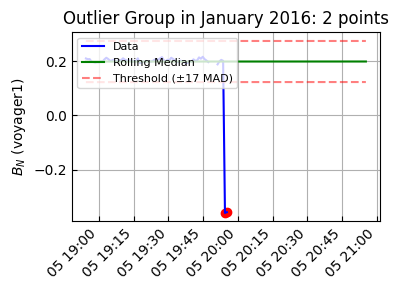


Outlier groups summary:
Group 1: January 2016, 2 points, duration: 0 days 00:00:48, starting at 2016-01-05 19:54


In [60]:
# Create a figure with subplots for each outlier group
if outlier_groups:
    # Create a grid of subplots (max 3 per row)
    n_groups = len(outlier_groups)
    n_cols = min(3, n_groups)  # Max 3 columns
    n_rows = (n_groups + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), constrained_layout=True
    )

    # Make axes indexable even if there's only one subplot
    if n_groups == 1:
        axes = np.array([axes])

    # Flatten axes array for easier indexing
    axes = np.array(axes).reshape(-1)

    # Format for the dates on x-axis
    date_format = DateFormatter("%d %H:%M")

    for i, group in enumerate(outlier_groups):
        if i >= len(axes):
            break

        # Get the first and last timestamp of the group
        first_timestamp = group["timestamp"].min()
        last_timestamp = group["timestamp"].max()

        # Get the surrounding 12 hours of data
        start_time = first_timestamp - pd.Timedelta(hours=1)
        end_time = last_timestamp + pd.Timedelta(hours=1)

        # Get window data
        window_data = df[comp][start_time:end_time]
        window_median = rolling_median[comp][start_time:end_time]

        # Plot the window data
        ax = axes[i]
        ax.plot(window_data.index, window_data.values, "b-", label="Data")
        ax.plot(window_median.index, window_median.values, "g-", label="Rolling Median")

        # Highlight all outliers in the group
        for timestamp in group["timestamp"]:
            ax.scatter(
                timestamp,
                df[comp].loc[timestamp],
                color="red",
                marker="o",
            )

        # Add threshold lines
        window_mad = rolling_mad[comp][start_time:end_time]
        upper_bound = window_median + threshold * window_mad
        lower_bound = window_median - threshold * window_mad
        ax.plot(
            upper_bound.index,
            upper_bound.values,
            "r--",
            alpha=0.5,
            label=f"Threshold (±{threshold} MAD)",
        )
        ax.plot(lower_bound.index, lower_bound.values, "r--", alpha=0.5)

        # Format the plot
        ax.xaxis.set_major_formatter(date_format)
        month_name = first_timestamp.strftime("%B %Y")
        n_points_in_group = len(group)
        ax.set_title(
            f'Outlier Group in {month_name}: {n_points_in_group} point{"s" if n_points_in_group > 1 else ""}'
        )
        ax.grid(True)

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=8, loc="upper left")
    axes[0].set_ylabel(f"{labels[comp]} ({spacecraft})")
    plt.tight_layout()
    #plt.subplots_adjust(top=0.95)
    plt.savefig(f"../results/cleaning/outliers_{spacecraft}_{year}_groups_{comp}.png", dpi=300)
    plt.show()

    # Print summary information
    print("\nOutlier groups summary:")
    for i, group_df in enumerate(outlier_groups):
        first_time = group_df["timestamp"].min()
        month_name = first_time.strftime("%B %Y")
        n_points = len(group_df)
        duration = group_df["timestamp"].max() - group_df["timestamp"].min()
        print(
            f"Group {i+1}: {month_name}, {n_points} point{'s' if n_points > 1 else ''}, "
            f"duration: {duration}, starting at {first_time.strftime('%Y-%m-%d %H:%M')}"
        )
else:
    print("No outliers found in the dataset.")

## Plot the biggest lag-1 increments

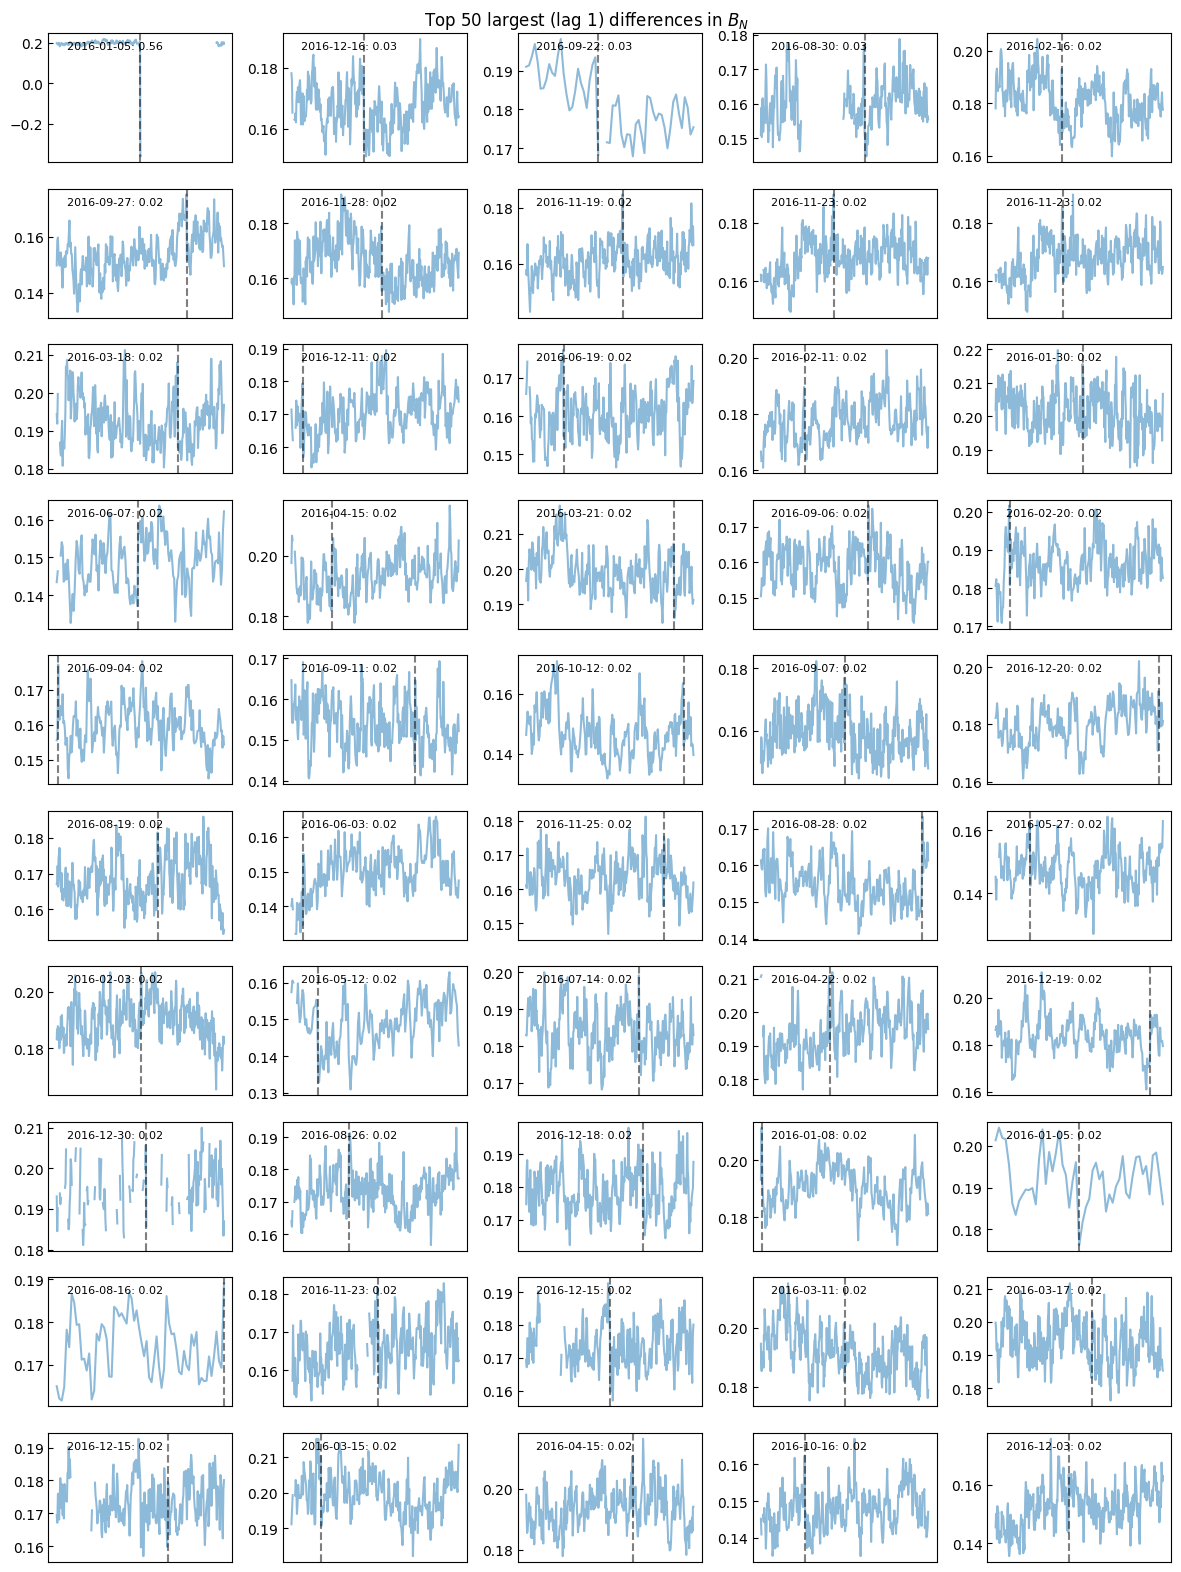

In [57]:
diffs = df[component].diff()

# Plot the 12hours around the top n most extreme differences
n = 50
time_window = pd.DateOffset(hours=3)

top_diffs = diffs.abs().nlargest(n)

fig, ax = plt.subplots(10, 5, figsize=(12, 16))
ax = ax.flatten()
for i, date in enumerate(top_diffs.index):
    ax[i].plot(df[date - time_window : date + time_window][component], alpha=0.5)
    ax[i].axvline(date, color="black", linestyle="--", alpha=0.5)
    ax[i].scatter(
        outliers[comp][date - time_window : date + time_window].index,
        outliers[comp][date - time_window : date + time_window],
        color="red",
        label="Outliers",
        marker="o",
        # Change the marker size
        s=4,
    )
    ax[i].annotate(
        f"{date.strftime('%Y-%m-%d')}: {top_diffs[date]:.2f}",
        (0.1, 0.9),
        xycoords="axes fraction",
        ha="left",
        va="center",
        fontsize=8
    )
    # Remove axis tickmarks
    ax[i].set_xticks([])
    # ax[i].set_yticks([])
    # plt.legend()
    # plt.title(f"Outliers around {date.strftime('%Y-%m-%d %H:%M:%S')}")
plt.suptitle(f"Top {n} largest (lag 1) differences in $B_N$")
plt.tight_layout()
plt.show()

In [ ]:
#sys.exit()

SystemExit: 

c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Interative plot with kurtosis

In [62]:
fig = make_subplots(
    rows=len(components),
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    specs=[[{"secondary_y": True}] for _ in components],
    # template="plotly_white",
)

# Iterate through each component and its corresponding subplot
for i, (comp, color) in enumerate(zip(components, colors)):
    fig.add_trace(
        go.Scatter(
            x=df[comp].index,
            y=df[comp],
            mode="lines",
            name=labels[comp],
            line=dict(width=1, color=color),
        ),
        row=i + 1,
        col=1,
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=rolling_kurt[comp].index,
            y=rolling_kurt[comp],
            mode="lines",
            name=f"{labels[comp]} Rolling Kurtosis",
            line=dict(width=0.8, color="#ff7f00"),
            yaxis=f"y{i+1}",
        ),
        row=i + 1,
        col=1,
        secondary_y=True,
    )

    fig.update_yaxes(
        title_text=comp,
        row=i + 1,
        col=1,
        secondary_y=False,
        title_font=dict(color=color),
    )


# Add vertical lines spanning all subplots
for outlier_time in all_outlier_times:
    fig.add_shape(
        go.layout.Shape(
            type="line",
            x0=outlier_time,
            x1=outlier_time,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="red", width=1.5),
        )
    )


fig.update_yaxes(
    title_text="100-pt Rolling Kurtosis",
    row=1,
    col=1,
    secondary_y=True,
    title_font=dict(color="#ff7f00"),
)
fig.update_layout(
    height=600,
    width=1200,
    title_text="LISM Mag Field with Hampel-Filtered Outliers and Rolling Kurtosis",
    showlegend=False,
    template="simple_white",
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Computing correlation scale

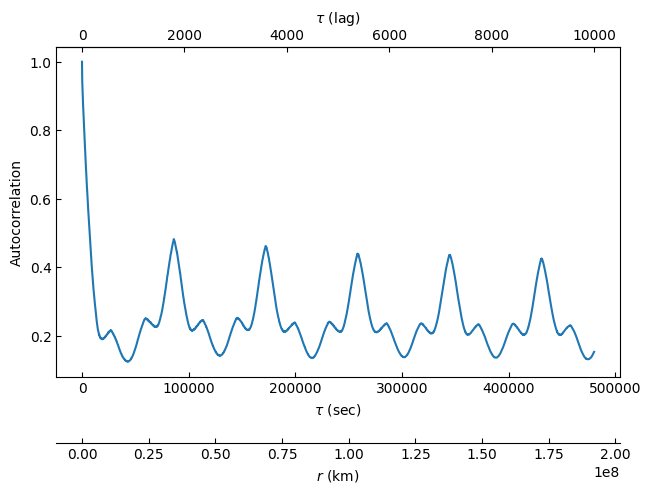

Correlation time = 9895.0s = 3.0 hours


In [ ]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df.BR, df.BT, df.BN],
    nlags=10000,  # Arbritrary large number
    plot=True,
)
tc_exp = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

print(f"Correlation time = {np.round(tc_exp)}s = {np.round(tc_exp/3600)} hours")

Calculating correlation time, using full 60-day dataset. Note highly wiggly ACF due to gaps. 

Also calculating $\lambda_C$ using integral method

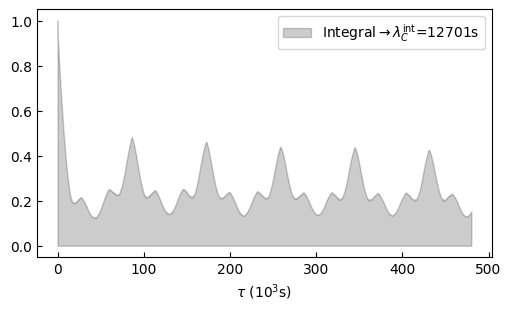

3.5281364358148237
hours


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
tc, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig, ax, True)
# print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")

plt.show()
print(tc / 60 / 60)
print("hours")

In [ ]:
print(
    "10 of these is ",
    np.round(10 * tc / 60 / 60 / 24, 2),
    "days, compared with full data length of",
    df.index[-1] - df.index[0],
)

10 of these is  1.47 days, compared with full data length of 2319 days 20:44:48


Note that this integral version is much longer, which will make the final interval lengths *slightly* more comparable with Fraternale's ints. (But note in either case the underlying ACF does look a bit silly)

#### Issues with comparing results

##### Complete SFs

- We are simplifying by down-sampling for ease of time, and approximating B_parallel with B_T

##### Corrected SFs
- We are computing vector SFs. Not only is not the same as them, but it also complicates the picture of re-scaling back to the original units. Chen (2012) work with normalised SFs may possibly help here.
- Not yet shown here, but below we perform our de-biasing of an interpolated version of this interval (shown by purple SFs). However, the correction factor is trained on 10 correlation lengths worth of data, with the SF calculated up to 2 $\lambda_C$, which, as shown by the vertical blue lines above, is much shorter than their intervals. 